In [1]:
import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn
import numpy as np
import random
import matplotlib.pyplot as plt
from IPython.display import clear_output

In [2]:
def prepare_sequence(seq, to_ix):
    idxs = [to_ix[w] for w in seq]
    tensor = torch.LongTensor(idxs)
    return autograd.Variable(tensor)


def create_dict(training_data):
    word_to_ix = {}
    for sent in training_data:
        for word in sent:
            if word not in word_to_ix:
                word_to_ix[word] = len(word_to_ix)
    ix_to_word = dict([(y, x) for (y, x) in enumerate(word_to_ix)])
    return word_to_ix, ix_to_word


def create_data(sentences):
    training_data = []
    for s in sentences:
        for i in range(len(s)):
            training_data.append(s)
            s = np.roll(s,-1).tolist()
    return training_data

In [3]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, hidden_dim)

        # The linear layer that maps from hidden state space to tag space
        self.hidden2voc = nn.Linear(hidden_dim, vocab_size)
        self.hidden = self.init_hidden()

    def init_hidden(self):
        # Before we've done anything, we dont have any hidden state.
        # Refer to the Pytorch documentation to see exactly
        # why they have this dimensionality.
        # The axes semantics are (num_layers, minibatch_size, hidden_dim)
        return (autograd.Variable(torch.zeros(1, 1, self.hidden_dim)),
                autograd.Variable(torch.zeros(1, 1, self.hidden_dim)))

    def forward(self, sentence):
        embeds = self.word_embeddings(sentence)
        lstm_out, self.hidden = self.lstm(embeds.view(len(sentence), 1, -1), self.hidden)
        voc_space = self.hidden2voc(lstm_out.view(len(sentence), -1))
        voc_scores = F.log_softmax(voc_space, dim=1)
        return voc_scores

In [4]:
sentences = ["The dog ate the apple . \n".split(' '), 
             "One cat drank milk . \n".split(' '),
             "A bird flew up high . \n".split(' '),
             "The rat ate the bread . \n".split(' '), 
             "Two cows drank milk . \n".split(' '),
             "A turtle swam up high . \n".split(' '),
             "The lion ate a person . \n".split(' '), 
             "One bat drank blood . \n".split(' '),
             "A tiger jumped up high . \n".split(' '),
             "The mouse ate the cheese . \n".split(' '), 
             "Two sheep drank water . \n".split(' '),
             "A horse jumped up high . \n".split(' '),
             "The car drove fast . \n".split(' '),
             "One dog drank the milk . \n".split(' '),
             "Two fish swam in water . \n".split(' '),
             "The bat ate the apple . \n".split(' '),
             "The bird flew fast . \n".split(' '),
             "A lion ate the sheep . \n".split(' '),]

sentences = ["THE DOG ATE THE APPLE . \n".split(' '), 
             "THE DOG DRANK THE WATER . \n".split(' '),
             "THE CAT ATE AN APPLE . \n".split(' '),
             "THE CAT DRANK THE MILK . \n".split(' '),
             
             "THE LION RAN FAST . \n".split(' '),
             "THE LION ATE THE DOG . \n".split(' '),
             "THE LION DRANK . \n".split(' '),
             "THE DOG RAN . \n".split(' ')]

sentences = ['I am Daniel \n I am Sam \n Sam I am \n \n That Sam-I-am \n That Sam-I-am ! \n I do not like \n That Sam-I-am \n \n Do you like \n Green eggs and ham \n \n I do not like them , \n Sam-I-am . \n I do not like \n Green eggs and ham . \n \n Would you like them \n Here or there ? \n \n I would not like them \n Here or there . \n I would not like them \n Anywhere . \n I do not like \n Green eggs and ham . \n I do not like them , \n Sam-I-am \n \n Would you like them \n In a house ? \n Would you like them \n With a mouse ? \n \n I do not like them \n In a house . \n I do not like them \n With a mouse . \n I do not like them \n Here or there . \n I do not like them \n Anywhere . \n I do not like green eggs and ham . \n I do not like them , Sam-I-am . \n \n Would you eat them \n In a box ? \n Would you eat them \n With a fox ? \n \n Not in a box . \n Not with a fox . \n Not in a house . \n Not with a mouse . \n I would not eat them here or there . \n I would not eat them anywhere . \n I would not eat green eggs and ham . \n I do not like them , Sam-I-am . \n \n Would you ? Could you ? \n In a car ? \n Eat them ! Eat them ! \n Here they are . \n \n I would not , \n Could not , \n In a car \n \n You may like them . \n You will see . \n You may like them \n In a tree ? \n \n I would not , could not in a tree . \n Not in a car ! You let me be . \n I do not like them in a box . \n I do not like them with a fox \n I do not like them in a house \n I do not like them with a mouse \n I do not like them here or there . \n I do not like them anywhere . \n I do not like green eggs and ham . \n I do not like them , Sam-I-am . \n \n A train ! A train ! \n A train ! A train ! \n Could you , would you \n On a train ? \n \n Not on a train ! Not in a tree ! \n Not in a car ! Sam ! Let me be ! \n I would not , could not , in a box . \n I could not , would not , with a fox . \n I will not eat them with a mouse \n I will not eat them in a house . \n I will not eat them here or there . \n I will not eat them anywhere . \n I do not like them , Sam-I-am . \n \n Say ! \n In the dark ? \n Here in the dark ! \n Would you , could you , in the dark ? \n \n I would not , could not , \n In the dark . \n \n Would you , could you , \n In the rain ? \n \n I would not , could not , in the rain . \n Not in the dark . \n Not on a train , \n Not in a car , Not in a tree . \n I do not like them , Sam , you see . \n Not in a house . Not in a box . \n Not with a mouse . Not with a fox . \n I will not eat them here or there . \n I do not like them anywhere ! \n \n You do not like \n Green eggs and ham ? \n \n I do not \n Like them , \n Sam-I-am . \n \n Could you , would you , \n With a goat ? \n \n I would not , \n Could not . \n With a goat ! \n \n Would you , could you , \n On a boat ? \n \n I could not , would not , on a boat . \n I will not , will not , with a goat . \n I will not eat them in the rain . \n I will not eat them on a train . \n Not in the dark ! \n Not in a tree ! \n Not in a car ! You let me be ! \n I do not like them in a box . \n I do not like them with a fox . \n I will not eat them in a house . \n I do not like them with a mouse . \n I do not like them here or there . \n I do not like them anywhere ! \n \n I do not like \n Green eggs \n And ham ! \n \n I do not like them , \n Sam-I-am . \n \n You do not like them . \n So you say . \n Try them ! Try them ! \n And you may . \n Try them and you may I say . \n \n Sam ! \n If you will let me be , \n I will try them . \n You will see . \n \n Say ! \n I like green eggs and ham ! \n I do ! I like them , Sam-I-am ! \n And I would eat them in a boat ! \n And I would eat them with a goat ... \n And I will eat them in the rain . \n And in the dark \n And on a train . \n And in a car . \n And in a tree . \n They are so good so good you see ! \n \n So I will eat them in a box . \n And I will eat them with a fox . \n And I will eat them in a house . \n And I will eat them with a mouse . \n And I will eat them here and there . \n Say ! I will eat them anywhere ! \n \n I do so like \n Green eggs and ham ! \n Thank you ! \n Thank you , \n Sam-I-am'.split(' ')]
sentences = ['I am Daniel \n I am Sam \n Sam I am \n'.split(' '), 'That Sam-I-am \n That Sam-I-am ! \n I do not like \n That Sam-I-am \n'.split(' '), 'Do you like \n Green eggs and ham \n'.split(' '), 'I do not like them , \n Sam-I-am . \n I do not like \n Green eggs and ham . \n'.split(' '), 'Would you like them \n Here or there ? \n'.split(' '), 'I would not like them \n Here or there . \n I would not like them \n Anywhere . \n I do not like \n Green eggs and ham . \n I do not like them , \n Sam-I-am \n'.split(' '), 'Would you like them \n In a house ? \n Would you like them \n With a mouse ? \n'.split(' '), 'I do not like them \n In a house . \n I do not like them \n With a mouse . \n I do not like them \n Here or there . \n I do not like them \n Anywhere . \n I do not like green eggs and ham . \n I do not like them , Sam-I-am . \n'.split(' '), 'Would you eat them \n In a box ? \n Would you eat them \n With a fox ? \n'.split(' '), 'Not in a box . \n Not with a fox . \n Not in a house . \n Not with a mouse . \n I would not eat them here or there . \n I would not eat them anywhere . \n I would not eat green eggs and ham . \n I do not like them , Sam-I-am . \n'.split(' '), 'Would you ? Could you ? \n In a car ? \n Eat them ! Eat them ! \n Here they are . \n'.split(' '), 'I would not , \n Could not , \n In a car \n'.split(' '), 'You may like them . \n You will see . \n You may like them \n In a tree ? \n'.split(' '), 'I would not , could not in a tree . \n Not in a car ! You let me be . \n I do not like them in a box . \n I do not like them with a fox \n I do not like them in a house \n I do not like them with a mouse \n I do not like them here or there . \n I do not like them anywhere . \n I do not like green eggs and ham . \n I do not like them , Sam-I-am . \n'.split(' '), 'A train ! A train ! \n A train ! A train ! \n Could you , would you \n On a train ? \n'.split(' '), 'Not on a train ! Not in a tree ! \n Not in a car ! Sam ! Let me be ! \n I would not , could not , in a box . \n I could not , would not , with a fox . \n I will not eat them with a mouse \n I will not eat them in a house . \n I will not eat them here or there . \n I will not eat them anywhere . \n I do not like them , Sam-I-am . \n'.split(' '), 'Say ! \n In the dark ? \n Here in the dark ! \n Would you , could you , in the dark ? \n'.split(' '), 'I would not , could not , \n In the dark . \n'.split(' '), 'Would you , could you , \n In the rain ? \n'.split(' '), 'I would not , could not , in the rain . \n Not in the dark . \n Not on a train , \n Not in a car , Not in a tree . \n I do not like them , Sam , you see . \n Not in a house . Not in a box . \n Not with a mouse . Not with a fox . \n I will not eat them here or there . \n I do not like them anywhere ! \n'.split(' '), 'You do not like \n Green eggs and ham ? \n'.split(' '), 'I do not \n Like them , \n Sam-I-am . \n'.split(' '), 'Could you , would you , \n With a goat ? \n'.split(' '), 'I would not , \n Could not . \n With a goat ! \n'.split(' '), 'Would you , could you , \n On a boat ? \n'.split(' '), 'I could not , would not , on a boat . \n I will not , will not , with a goat . \n I will not eat them in the rain . \n I will not eat them on a train . \n Not in the dark ! \n Not in a tree ! \n Not in a car ! You let me be ! \n I do not like them in a box . \n I do not like them with a fox . \n I will not eat them in a house . \n I do not like them with a mouse . \n I do not like them here or there . \n I do not like them anywhere ! \n'.split(' '), 'I do not like \n Green eggs \n And ham ! \n'.split(' '), 'I do not like them , \n Sam-I-am . \n'.split(' '), 'You do not like them . \n So you say . \n Try them ! Try them ! \n And you may . \n Try them and you may I say . \n'.split(' '), 'Sam ! \n If you will let me be , \n I will try them . \n You will see . \n'.split(' '), 'Say ! \n I like green eggs and ham ! \n I do ! I like them , Sam-I-am ! \n And I would eat them in a boat ! \n And I would eat them with a goat ... \n And I will eat them in the rain . \n And in the dark \n And on a train . \n And in a car . \n And in a tree . \n They are so good so good you see ! \n'.split(' '), 'So I will eat them in a box . \n And I will eat them with a fox . \n And I will eat them in a house . \n And I will eat them with a mouse . \n And I will eat them here and there . \n Say ! I will eat them anywhere ! \n'.split(' '), 'I do so like \n Green eggs and ham ! \n Thank you ! \n Thank you , \n Sam-I-am'.split(' ')]

training_data = create_data(sentences)
word_to_ix, ix_to_word = create_dict(training_data)
print(word_to_ix)
print(ix_to_word)

EMBEDDING_DIM = 2*len(word_to_ix)
HIDDEN_DIM = EMBEDDING_DIM*2


{'I': 0, 'am': 1, 'Daniel': 2, '\n': 3, 'Sam': 4, 'That': 5, 'Sam-I-am': 6, '!': 7, 'do': 8, 'not': 9, 'like': 10, 'Do': 11, 'you': 12, 'Green': 13, 'eggs': 14, 'and': 15, 'ham': 16, 'them': 17, ',': 18, '.': 19, 'Would': 20, 'Here': 21, 'or': 22, 'there': 23, '?': 24, 'would': 25, 'Anywhere': 26, 'In': 27, 'a': 28, 'house': 29, 'With': 30, 'mouse': 31, 'green': 32, 'eat': 33, 'box': 34, 'fox': 35, 'Not': 36, 'in': 37, 'with': 38, 'here': 39, 'anywhere': 40, 'Could': 41, 'car': 42, 'Eat': 43, 'they': 44, 'are': 45, 'You': 46, 'may': 47, 'will': 48, 'see': 49, 'tree': 50, 'could': 51, 'let': 52, 'me': 53, 'be': 54, 'A': 55, 'train': 56, 'On': 57, 'on': 58, 'Let': 59, 'Say': 60, 'the': 61, 'dark': 62, 'rain': 63, 'Like': 64, 'goat': 65, 'boat': 66, 'And': 67, 'So': 68, 'say': 69, 'Try': 70, 'If': 71, 'try': 72, '...': 73, 'They': 74, 'so': 75, 'good': 76, 'Thank': 77}
{0: 'I', 1: 'am', 2: 'Daniel', 3: '\n', 4: 'Sam', 5: 'That', 6: 'Sam-I-am', 7: '!', 8: 'do', 9: 'not', 10: 'like', 11: 'D

In [6]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(word_to_ix))
loss_function = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)

EPOCHS = 200
loss_save = []
for epoch in range(EPOCHS):
    if (epoch+1) % 5 == 0:
        clear_output(wait=True)
        print("Epoch... ", (epoch+1), "out of", EPOCHS)
#     sentences = random.sample(sentences, len(sentences))
    for sentence in sentences:
        tags = np.roll(sentence,-1).tolist()

        # Step 1. Remember that Pytorch accumulates gradients.
        # We need to clear them out before each instance
        model.zero_grad()

        # Also, we need to clear out the hidden state of the LSTM,
        # detaching it from its history on the last instance.
        model.hidden = model.init_hidden()

        sentence_in = prepare_sequence(sentence, word_to_ix)
        targets = prepare_sequence(tags, word_to_ix)
  
        tag_scores = model(sentence_in)

        loss = loss_function(tag_scores, targets)
        loss.backward()
        loss_save.append(loss.data)
        optimizer.step()

Epoch...  200 out of 200


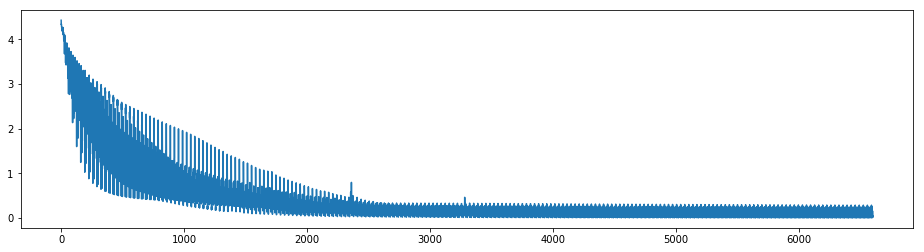

In [7]:
plt.figure(figsize = [16,4])
plt.plot(loss_save, '-', ms=3)
plt.show()

In [10]:
input_word = 'Sam'
print(input_word, end=' ')

model.hidden = model.init_hidden()

for i in range(200):
    inputs = prepare_sequence([input_word], word_to_ix)
    
    tag_scores = model(inputs)
    
    input_word = ix_to_word[int(tag_scores.max(dim=1)[1])]
    print(input_word, end=' ')

Sam ! 
 If you will let me be , 
 I will try them . 
 You will see . 
 Sam Sam ! 
 Sam ! 
 I would not , could not , in a boat . 
 Not in the dark ! 
 Not in a car ! Not in a tree ! 
 I do not like them , Sam , you see . 
 Not in a house . Not in a box . 
 Not with a mouse . Not with a fox . 
 I will not eat them here or there . 
 I do not like them anywhere ! 
 I do not like green eggs and ham . 
 I do not like them , Sam-I-am . 
 I do not like green eggs and ham . 
 I do not like them , Sam-I-am . 
 I do not like green eggs and ham . 
 I do not like them , Sam-I-am . 
 I do not like green eggs and ham . 
 I do not like them , Sam-I-am . 
 I do not like green eggs and ham . 
 I do not like them 